# pySCENIC protocol: sunhye 2nd experiment

June 2020

Dataset: 2nd experiment from SHL

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


#### set variables for file paths to read from and write to:

In [2]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj'

In [3]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
loom_file = 'output/scenic/allfeatures_pt2_seu-final.loom'

adata_file = loom_file.replace("-final.loom", ".h5ad")
# adata_file = 'output/scenic/allfeatures_only_pt_w_ctrl_seu.h5ad'



In [4]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
MulticoreTSNE       NA
PIL                 7.2.0
anndata             0.7.4
attr                20.2.0
backcall            0.2.0
boltons             NA
cairo               1.19.1
cffi                1.11.5
cloudpickle         1.6.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.10.1
dask                1.0.0
dateutil            2.8.1
decorator           4.4.2
frozendict          NA
get_version         2.1
h5py                2.10.0
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.0
ipython_genutils    0.2.0
jedi                0.17.1
joblib              0.16.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.33.0+1.g022ab0f
loompy              3.0.6
louvain             0.6.1
matplotlib          3.3.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
networkx            2.5
numba               0.50.1
numexpr             2.7.

## Extract relevant data from the integrated loom file

In [5]:
# scenic output
lf = lp.connect( loom_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [6]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [7]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [8]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [9]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [10]:
regulons.keys()

dict_keys(['BACH1_(+)', 'DDIT3_(+)', 'GTF3A_(+)', 'HES6_(+)', 'HSF1_(+)', 'KDM5B_(+)', 'NR2F6_(+)', 'RAX_(+)', 'RXRG_(+)', 'SOX4_(+)', 'TFDP1_(+)', 'ZNF770_(+)'])

In [12]:
myregulon = 'BACH1_(+)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

'There are 5 genes in BACH1_(+).'

## distribution of number of genes per regulon

In [13]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count    12.000000
mean     15.000000
std      22.895017
min       3.000000
25%       7.000000
50%       8.000000
75%      11.500000
max      87.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [14]:
adata = sc.read( loom_file, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [15]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [16]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [17]:
sc._utils.sanitize_anndata( adata )

... storing 'ClusterID' as categorical
... storing 'Clusterings' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'Regulons' as categorical


In [18]:
adata_h5ad = sc.read(adata_file)

metadata = adata_h5ad.obs

new_adata_obs = adata.obs.join(metadata, how = "left")

In [19]:
adata_h5ad

AnnData object with n_obs × n_vars = 84 × 56267
    obs: 'nCount_RNA', 'nFeature_RNA', 'day', 'treatment_group', 'index_i7', 'i7_bases', 'index_i5', 'i5_bases', 'lane', 'custom_cluster', 'sample_number', 'sample_id', 'names', 'gene_snn_res.0.2', 'seurat_clusters', 'gene_snn_res.0.4', 'gene_snn_res.0.6', 'gene_snn_res.0.8', 'gene_snn_res.1', 'gene_snn_res.1.2', 'gene_snn_res.1.4', 'gene_snn_res.1.6', 'gene_snn_res.1.8', 'gene_snn_res.2', 'S.Score', 'G2M.Score', 'Phase', 'percent.mt', 'pt1_clusters', 'pt2_clusters', 'nCount_gene', 'nFeature_gene', 'nCount_transcript', 'nFeature_transcript', 'transcript_snn_res.0.2', 'transcript_snn_res.0.4', 'transcript_snn_res.0.6', 'transcript_snn_res.0.8', 'transcript_snn_res.1', 'transcript_snn_res.1.2', 'transcript_snn_res.1.4', 'transcript_snn_res.1.6', 'transcript_snn_res.1.8', 'transcript_snn_res.2'
    var: 'name'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [20]:
adata.obs = new_adata_obs
adata.obs.columns

Index(['ClusterID', 'Clusterings', 'Louvain_clusters_Scanpy', 'Percent_mito',
       'nGene', 'nUMI', 'nCount_RNA', 'nFeature_RNA', 'day', 'treatment_group',
       'index_i7', 'i7_bases', 'index_i5', 'i5_bases', 'lane',
       'custom_cluster', 'sample_number', 'sample_id', 'names',
       'gene_snn_res.0.2', 'seurat_clusters', 'gene_snn_res.0.4',
       'gene_snn_res.0.6', 'gene_snn_res.0.8', 'gene_snn_res.1',
       'gene_snn_res.1.2', 'gene_snn_res.1.4', 'gene_snn_res.1.6',
       'gene_snn_res.1.8', 'gene_snn_res.2', 'S.Score', 'G2M.Score', 'Phase',
       'percent.mt', 'pt1_clusters', 'pt2_clusters', 'nCount_gene',
       'nFeature_gene', 'nCount_transcript', 'nFeature_transcript',
       'transcript_snn_res.0.2', 'transcript_snn_res.0.4',
       'transcript_snn_res.0.6', 'transcript_snn_res.0.8',
       'transcript_snn_res.1', 'transcript_snn_res.1.2',
       'transcript_snn_res.1.4', 'transcript_snn_res.1.6',
       'transcript_snn_res.1.8', 'transcript_snn_res.2'],
      dtype

In [21]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [23]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [24]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [25]:
# df_motifs = load_motifs('reg.csv')

In [26]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [27]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [28]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


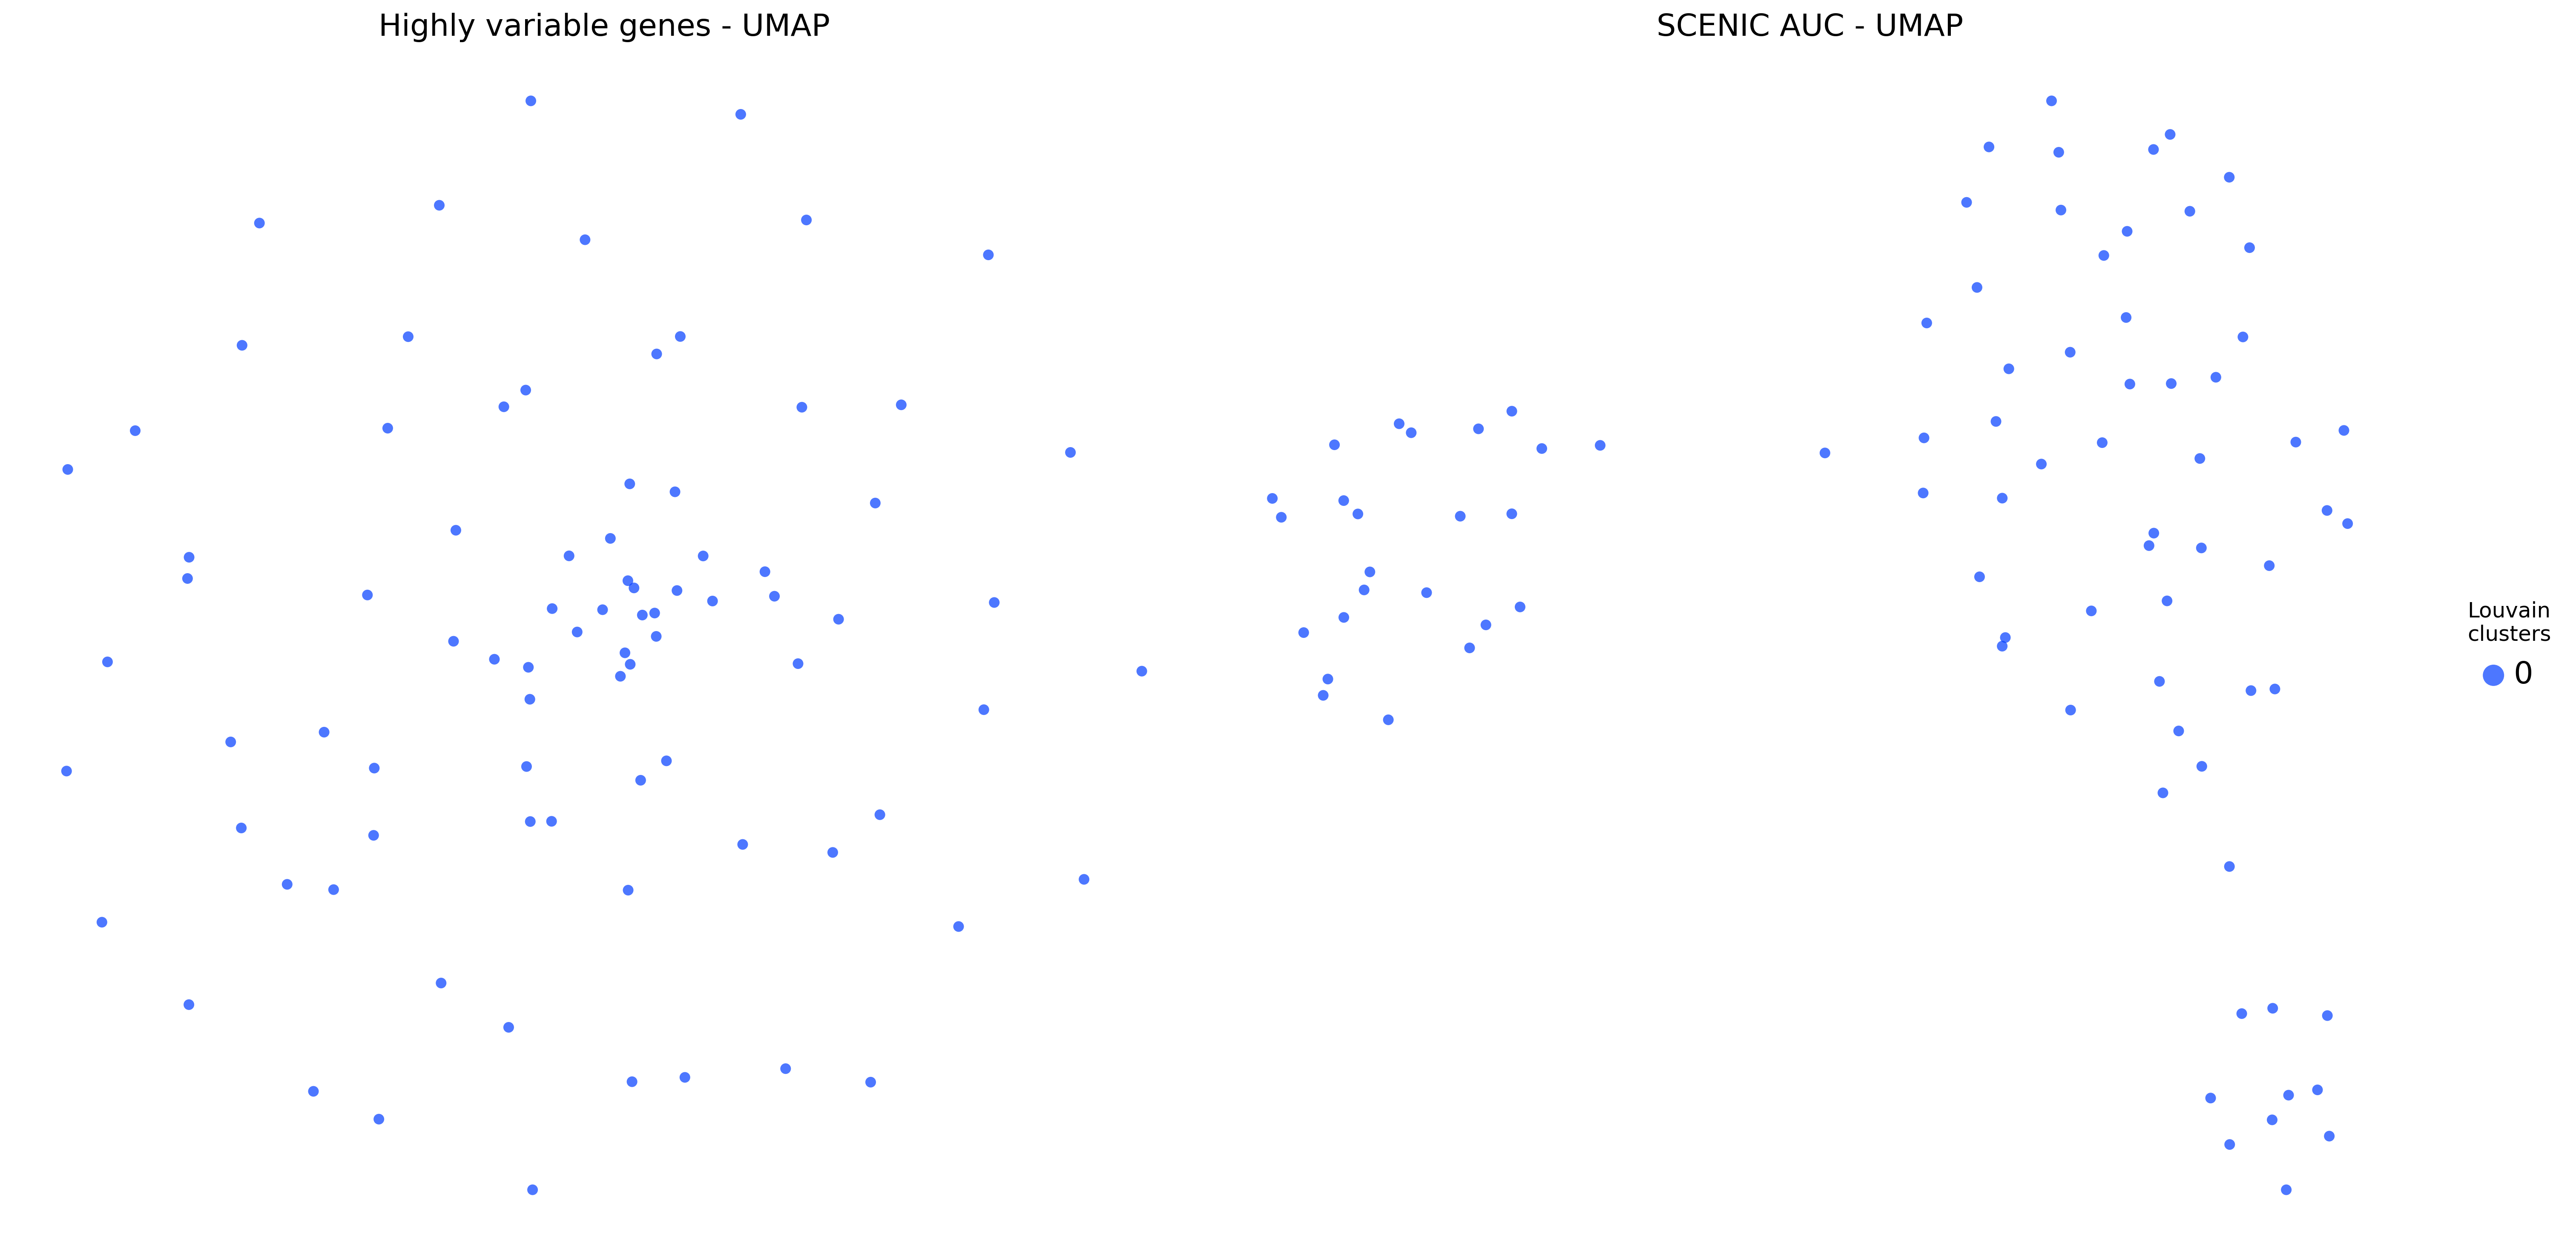

In [29]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [30]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [31]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = Louvain clusters at resolution 1.6

In [32]:
metavar="pt2_clusters"

### Calculate RSS

In [33]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] )
rss_louvain

BACH1_(+)  DDIT3_(+)  GTF3A_(+)  HES6_(+)  HSF1_(+)  KDM5B_(+)  NR2F6_(+)  \
2b   0.324272   0.356535   0.368077  0.322684  0.259864   0.365129   0.368396   
0    0.234780   0.208651   0.228320  0.215914  0.183123   0.224542   0.223439   
2a   0.208679   0.226565   0.237822  0.232073  0.180302   0.228959   0.236687   
2c   0.352651   0.425707   0.407790  0.364428  0.295859   0.421585   0.421804   
2e   0.255469   0.313427   0.325538  0.273223  0.336152   0.336670   0.318015   
2d   0.373895   0.365881   0.353958  0.348265  0.245091   0.335173   0.345238   

     RAX_(+)  RXRG_(+)  SOX4_(+)  TFDP1_(+)  ZNF770_(+)  
2b  0.354730  0.362033  0.309413   0.371952    0.356534  
0   0.227406  0.226911  0.204438   0.235797    0.214092  
2a  0.234888  0.236445  0.222196   0.210842    0.243142  
2c  0.420447  0.415157  0.353231   0.386816    0.385531  
2e  0.289874  0.312726  0.366560   0.281322    0.253138  
2d  0.362927  0.359550  0.237480   0.336799    0.310459

In [34]:
rss_louvain.to_csv('output/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

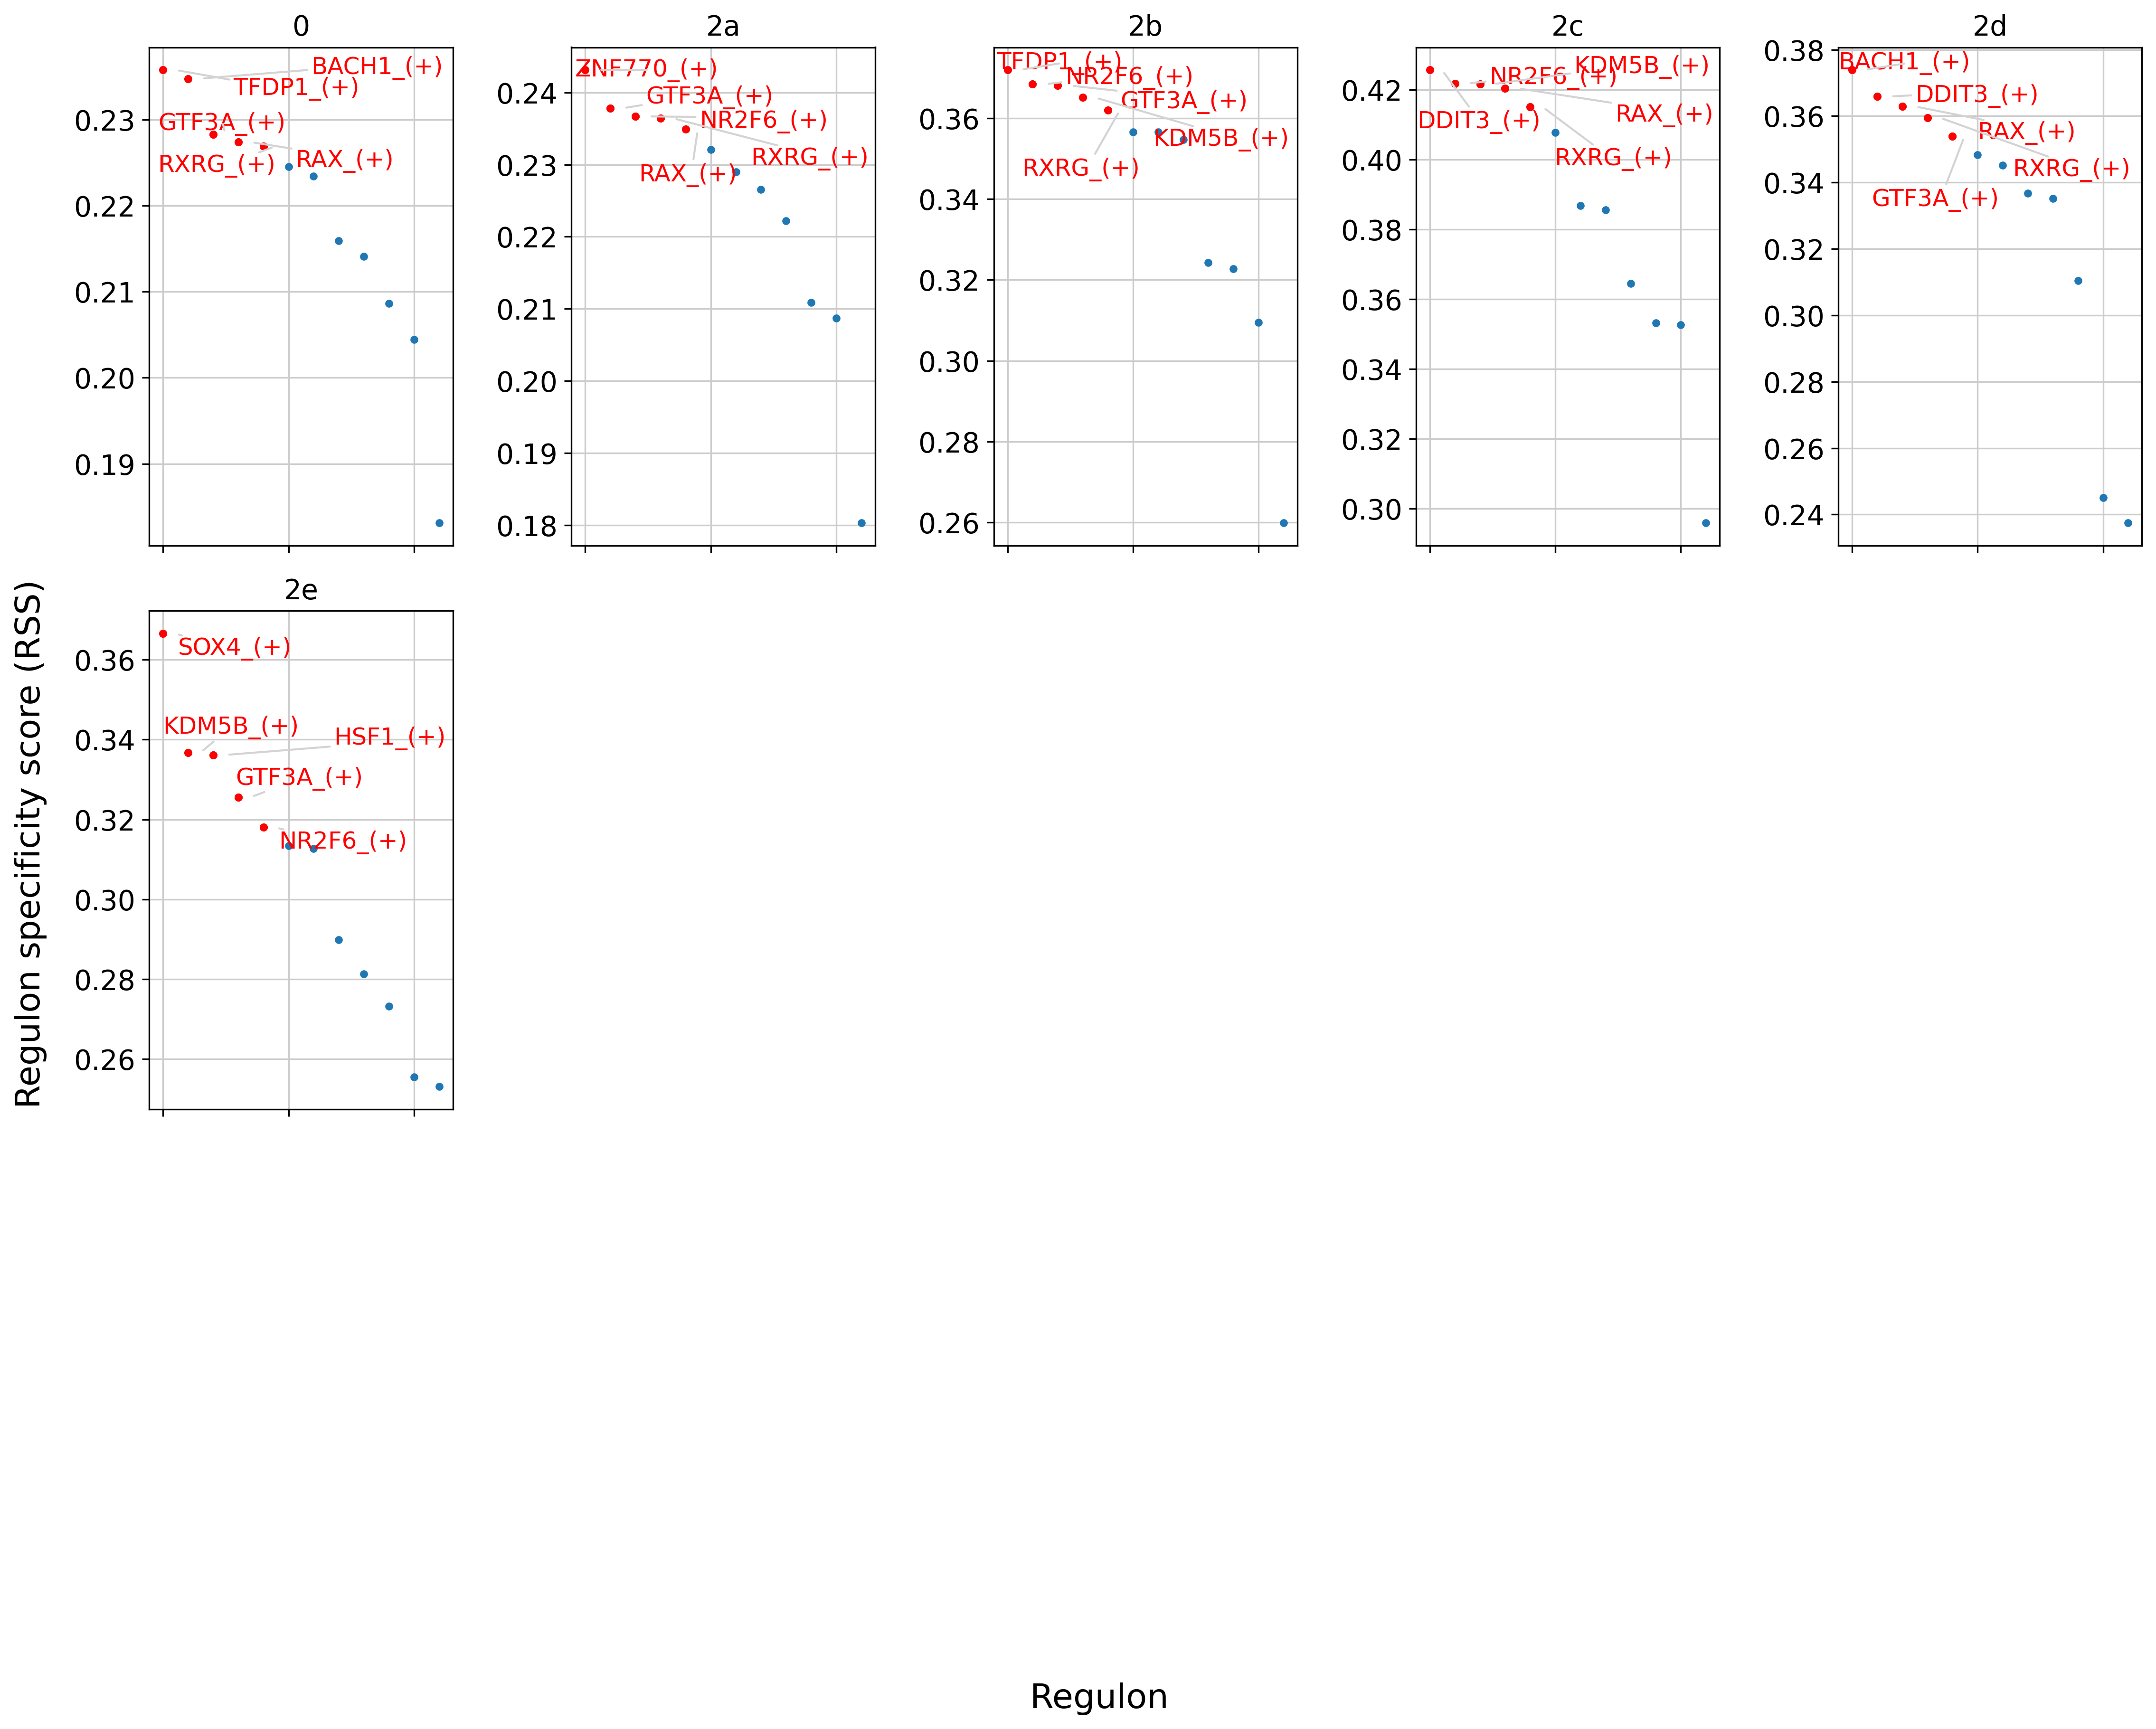

In [35]:
cats = sorted( list(set(cellAnnot[metavar].dropna())) )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [36]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [37]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby(metavar)[topreg].mean()
mean_regulon_by_meta

ZNF770_(+)  BACH1_(+)  TFDP1_(+)  NR2F6_(+)  SOX4_(+)  \
pt2_clusters                                                          
0               0.092542   0.091012   0.070248   0.392635  0.074236   
2a              0.147756   0.049588   0.036456   0.414341  0.105837   
2b              0.131040   0.072439   0.070480   0.438559  0.112987   
2c              0.126589   0.064993   0.055852   0.440069  0.116740   
2d              0.109436   0.100146   0.061643   0.439105  0.047665   
2e              0.079544   0.052507   0.043148   0.404765  0.188756   

              KDM5B_(+)   RAX_(+)  RXRG_(+)  DDIT3_(+)  GTF3A_(+)  HSF1_(+)  
pt2_clusters                                                                 
0              0.067559  0.333519  0.510718   0.220317   0.432852  0.003026  
2a             0.059799  0.318577  0.493329   0.280111   0.418688  0.002006  
2b             0.071603  0.315994  0.503692   0.337755   0.431781  0.008988  
2c             0.073426  0.345628  0.506588   0.373404   0.401445  0.012016  
2d             0.068821  0.385304  0.578201   0.417656   0.463320  0.009506  
2e             0.080216  0.245891  0.470767   0.333034   0.427571  0.019641

#### Generate a Z-score for each regulon to enable comparison between regulons

In [38]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [39]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [40]:
cellAnnot.index = cellAnnot.index.str.replace("ds20170407_S", "ds20170407-")
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['shl20171031-078', 'shl20171031-046', 'shl20171031-057',
       'shl20171031-071', 'shl20171031-060', 'shl20171031-064',
       'shl20171031-077', 'shl20171031-066', 'shl20171031-069',
       'shl20171031-154', 'shl20171031-083', 'shl20171031-144',
       'shl20171031-168', 'shl20171031-149', 'shl20171031-161',
       'shl20171031-085', 'shl20171031-076', 'shl20171031-044',
       'shl20171031-074', 'shl20171031-051', 'shl20171031-055',
       'shl20171031-058', 'shl20171031-065', 'shl20171031-075',
       'shl20171031-153', 'shl20171031-067', 'shl20171031-072',
       'shl20171031-073', 'shl20171031-237', 'shl20171031-231',
       'shl20171031-228', 'shl20171031-258', 'shl20171031-174',
       'shl20171031-167', 'shl20171031-163', 'shl20171031-264',
       'shl20171031-158', 'shl20171031-257', 'shl20171031-176',
       'shl20171031-160', 'shl20171031-151', 'shl20171031-135',
       'shl20171031-138', 'shl20171031-132', 'shl20171031-131',
       'shl20171031-140', 'shl20171031-0

In [41]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [42]:
cats

['0', '2a', '2b', '2c', '2d', '2e']

In [43]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar].dropna() ]

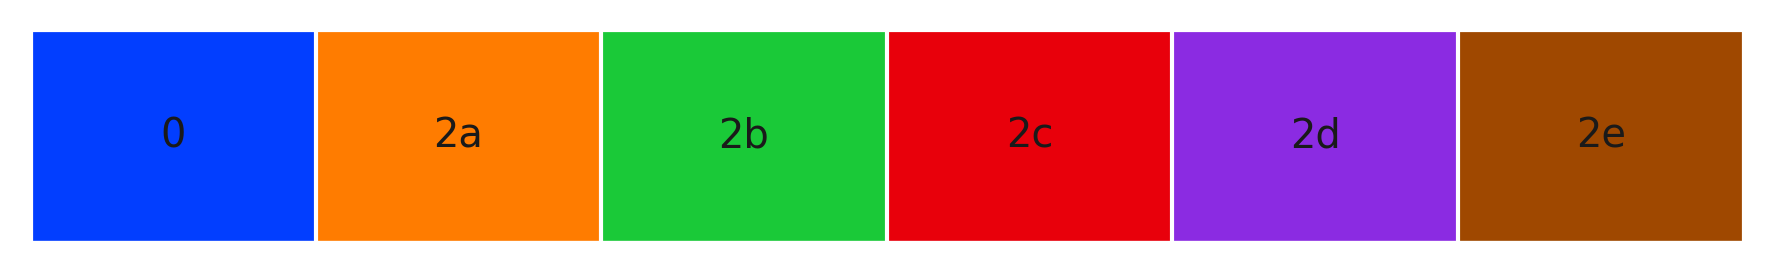

In [44]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

Text(0.5, 24.066666666666585, '')

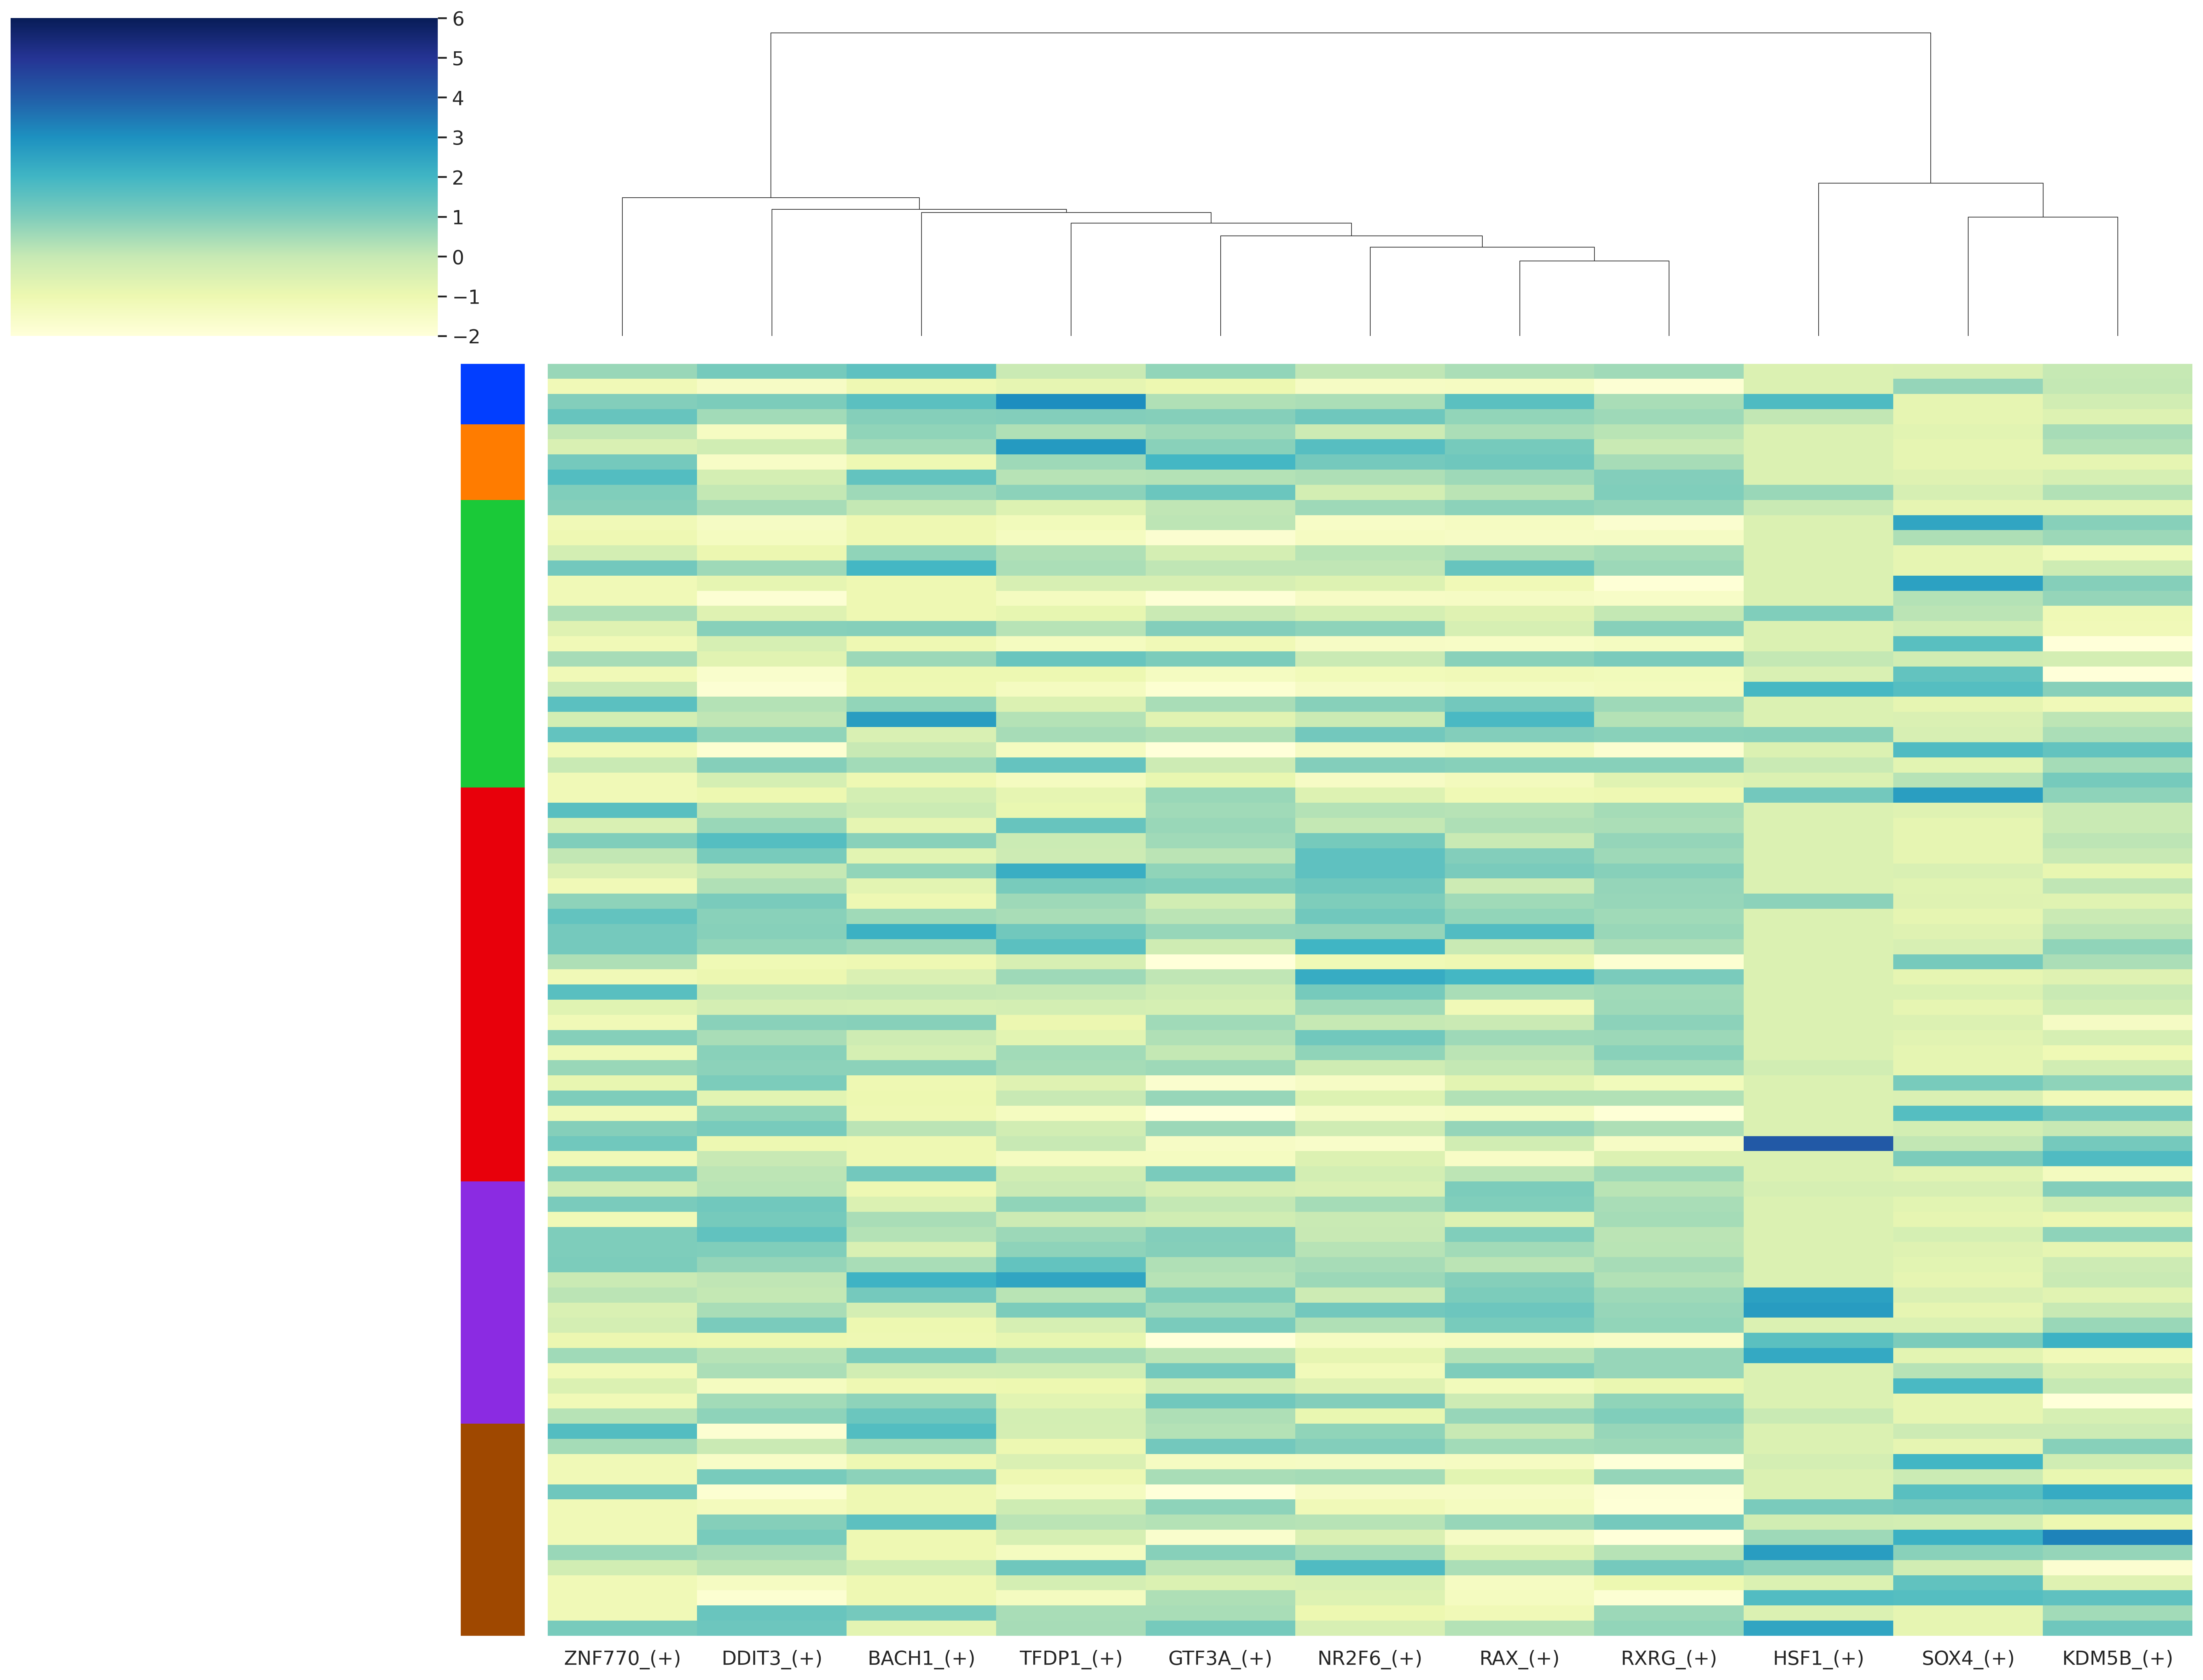

In [45]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [46]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [47]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000042


In [48]:
binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
binary_mtx.head()

BACH1_(+)  DDIT3_(+)  GTF3A_(+)  HES6_(+)  HSF1_(+)  \
shl20171031-078          1          0          0         1         0   
shl20171031-046          0          0          0         0         0   
shl20171031-057          1          0          0         0         0   
shl20171031-071          1          0          0         0         0   
shl20171031-060          0          0          0         1         0   

                 KDM5B_(+)  NR2F6_(+)  RAX_(+)  RXRG_(+)  SOX4_(+)  TFDP1_(+)  \
shl20171031-078          0          1        1         0         0          1   
shl20171031-046          0          0        0         0         0          0   
shl20171031-057          0          1        1         0         0          0   
shl20171031-071          0          1        1         0         0          0   
shl20171031-060          0          1        1         0         0          0   

                 ZNF770_(+)  
shl20171031-078           1  
shl20171031-046           0  
shl20171031-057           0  
shl20171031-071           0  
shl20171031-060           1

### Show the AUC distributions for selected regulons

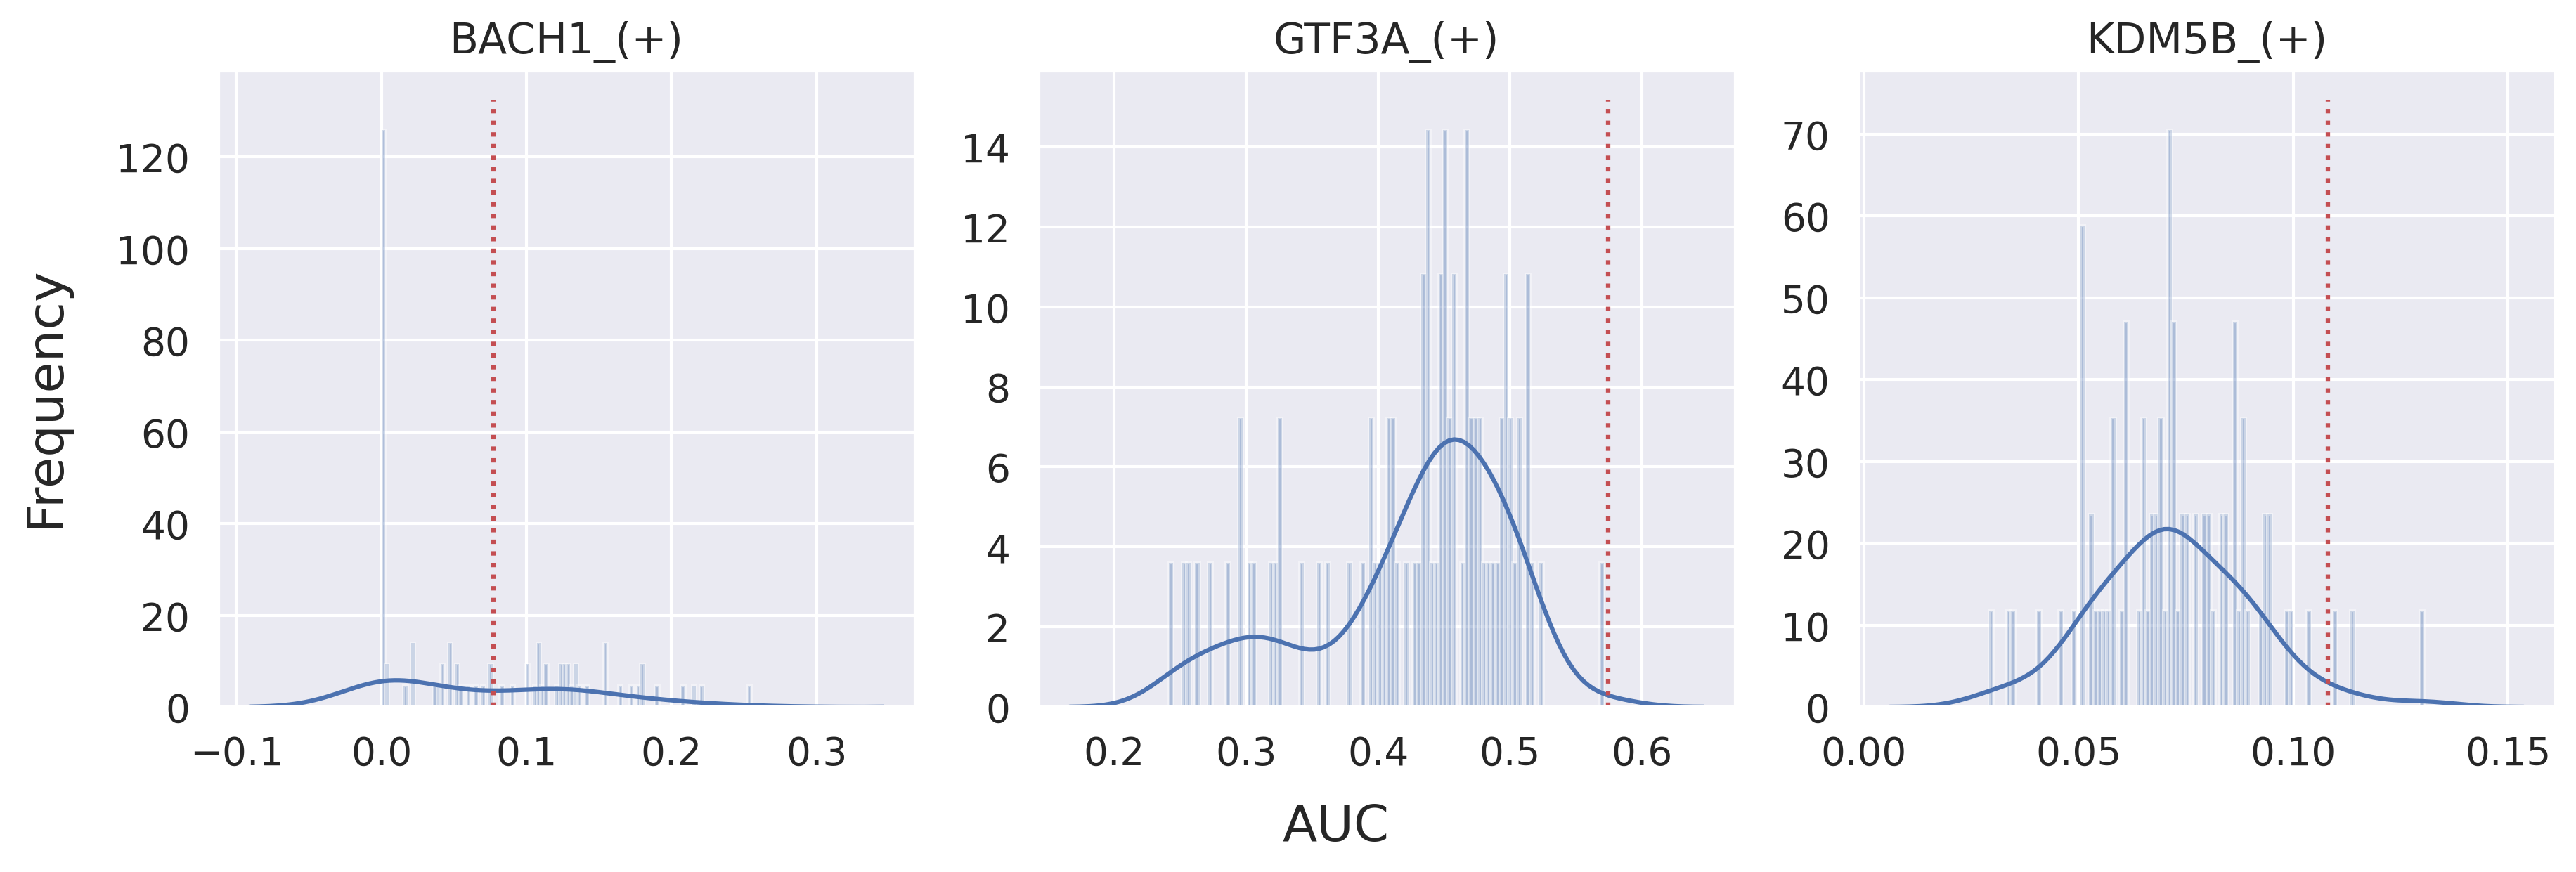

In [50]:
# select regulons:
r = [ 'BACH1_(+)', 'GTF3A_(+)', 'KDM5B_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('output/scenic/scenic-binaryPlot.pdf', dpi=600, bbox_inches='tight')

# display regulon scores on umap

In [51]:
adata_h5ad.obs[auc_mtx.columns] = auc_mtx

In [52]:
adata_h5ad.obs

nCount_RNA  nFeature_RNA     day treatment_group index_i7  \
shl20171031-044  4.984492e+06         11408   day_3           sh733     N706   
shl20171031-046  3.790317e+06          8871   day_3           sh733     N706   
shl20171031-051  5.630120e+06         11277   day_3           sh733     N707   
shl20171031-055  4.802184e+06         11444   day_3           sh733     N707   
shl20171031-057  5.442058e+06         10055   day_3           sh733     N710   
...                       ...           ...     ...             ...      ...   
shl20171031-361  4.634279e+06         11241   day_9           sh737     N711   
shl20171031-409  3.693020e+06          8499  day_12           sh733     N719   
shl20171031-418  4.238605e+06          8621  day_12           sh733     N720   
shl20171031-453  4.242492e+06         10694  day_12           sh737     N724   
shl20171031-512  5.252724e+06         10727  day_15           sh733     N704   

                 i7_bases index_i5  i5_bases  lane custom_cluster  ...  \
shl20171031-044  TAGGCATG     S506  TATGCAGT   2.0            c22  ...   
shl20171031-046  TAGGCATG     S508  AGGCTTAG   2.0  c1_cluster_11  ...   
shl20171031-051  CTCTCTAC     S505  CTCCTTAC   2.0            c22  ...   
shl20171031-055  CTCTCTAC     S510  ATTAGACG   2.0            c22  ...   
shl20171031-057  CGAGGCTG     S502  ATAGAGAG   2.0  c1_cluster_11  ...   
...                   ...      ...       ...   ...            ...  ...   
shl20171031-361  AAGAGGCA     S505  CTCCTTAC   6.0            c55  ...   
shl20171031-409  GCGTAGTA     S505  CTCCTTAC   6.0            c55  ...   
shl20171031-418  CGGAGCCT     S506  TATGCAGT   6.0            c55  ...   
shl20171031-453  ACTGAGCG     S510  ATTAGACG   4.0            c55  ...   
shl20171031-512  TCCTGAGC     S515  AGCTAGAA   5.0            c55  ...   

                 GTF3A_(+)  HES6_(+)  HSF1_(+) KDM5B_(+) NR2F6_(+)   RAX_(+)  \
shl20171031-044   0.482212  0.060778  0.000000  0.072338  0.440912  0.384992   
shl20171031-046   0.354308  0.000000  0.000000  0.073062  0.284936  0.125292   
shl20171031-051   0.450417  0.130973  0.049200  0.067364  0.468594  0.555531   
shl20171031-055   0.494886  0.016732  0.012538  0.061604  0.556643  0.434575   
shl20171031-057   0.469872  0.061790  0.000000  0.080057  0.414341  0.383546   
...                    ...       ...       ...       ...       ...       ...   
shl20171031-361   0.437465  0.092140  0.028448  0.040503  0.607226  0.384658   
shl20171031-409   0.387771  0.000000  0.000000  0.061362  0.384769  0.122624   
shl20171031-418   0.453085  0.000000  0.047903  0.099405  0.371762  0.132852   
shl20171031-453   0.456976  0.176498  0.000000  0.081399  0.329183  0.161645   
shl20171031-512   0.512173  0.117432  0.063554  0.094799  0.387660  0.364314   

                 RXRG_(+)  SOX4_(+) TFDP1_(+) ZNF770_(+)  
shl20171031-044  0.585143  0.043469  0.054774   0.179507  
shl20171031-046  0.267987  0.210228  0.023406   0.000000  
shl20171031-051  0.570216  0.000000  0.186411   0.211673  
shl20171031-055  0.590166  0.000000  0.097755   0.254475  
shl20171031-057  0.541422  0.010784  0.070937   0.123995  
...                   ...       ...       ...        ...  
shl20171031-361  0.670676  0.074263  0.111883   0.088975  
shl20171031-409  0.381464  0.320956  0.044119   0.000000  
shl20171031-418  0.267634  0.347304  0.000000   0.000000  
shl20171031-453  0.593138  0.000000  0.074948   0.000000  
shl20171031-512  0.609975  0.000000  0.077462   0.228794  

[84 rows x 56 columns]

In [53]:
# mean_regulon_by_meta.loc[:,"CREB3_(+)"]

In [58]:
adata_pca = pd.read_csv("output/scenic/martin_pc_output.csv", index_col = 0)
adata_pca.index

Index(['shl20171031-108', 'shl20171031-109', 'shl20171031-110',
       'shl20171031-111', 'shl20171031-112', 'shl20171031-113',
       'shl20171031-114', 'shl20171031-115', 'shl20171031-116',
       'shl20171031-117',
       ...
       'shl20171031-073', 'shl20171031-074', 'shl20171031-075',
       'shl20171031-076', 'shl20171031-077', 'shl20171031-078',
       'shl20171031-079', 'shl20171031-082', 'shl20171031-083',
       'shl20171031-085'],
      dtype='object', length=260)

In [59]:
myindex = adata_h5ad.obs.index
adata_pca0 = adata_pca.loc[myindex,]
adata_pca = adata_pca0.to_numpy()

In [60]:
# pd.DataFrame(adata_h5ad.obsm['X_pca']).shape
adata_h5ad.obsm['X_pca'][:,:20] = adata_pca

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


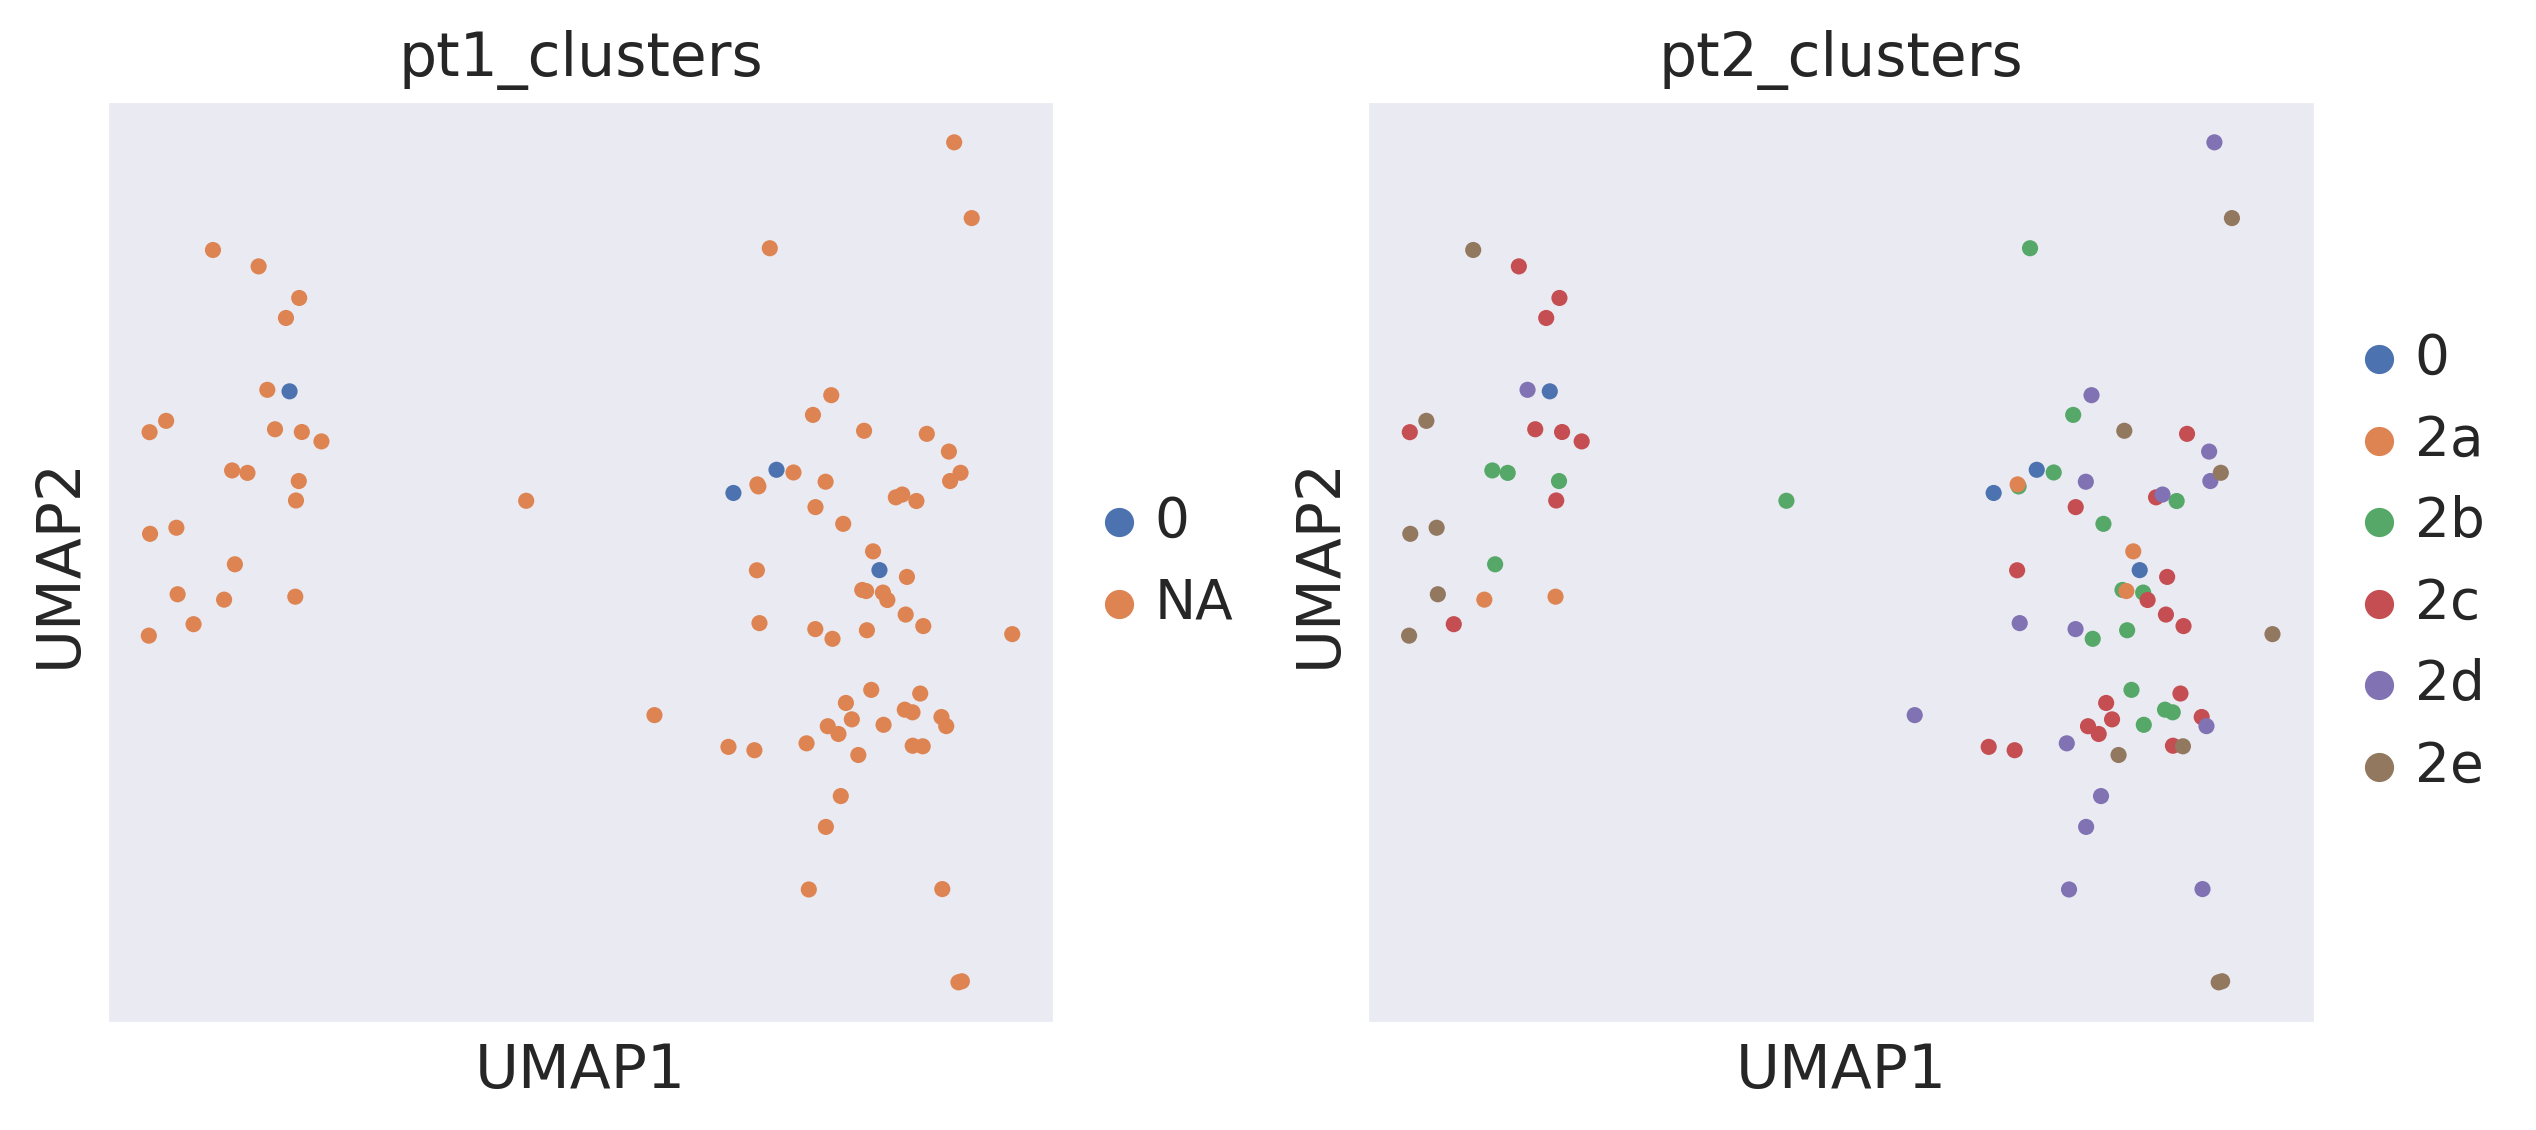

In [61]:
adata_h5ad.obs.columns
sc.pl.umap(adata_h5ad, color=['pt1_clusters', 'pt2_clusters'], size=60, save='.pdf')

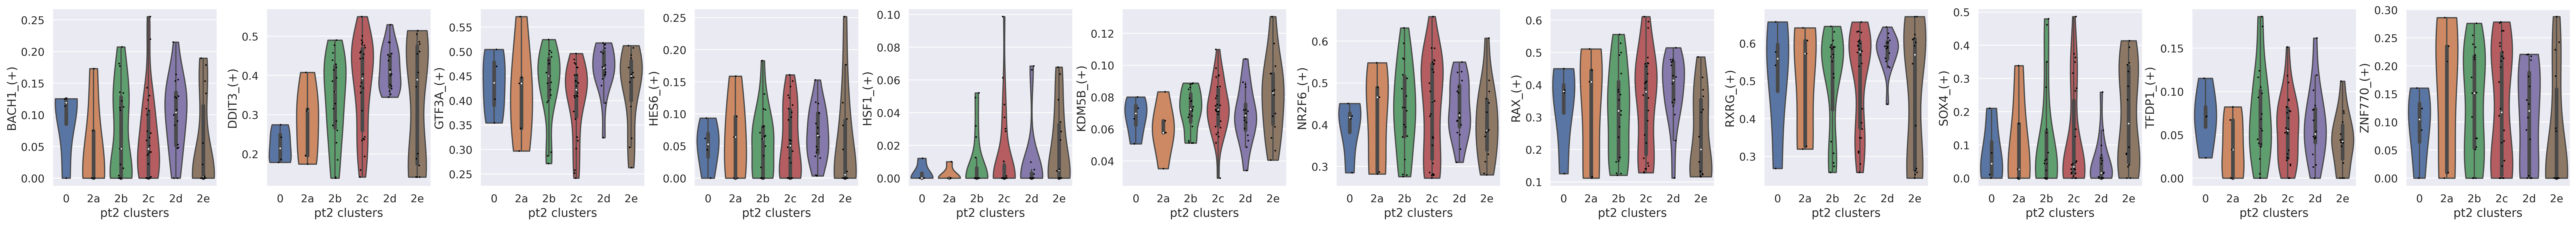

In [62]:
adata_h5ad.obs.pt2_clusters

sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt2_clusters", log=False, stripplot=True, size = 2, inner = "box")

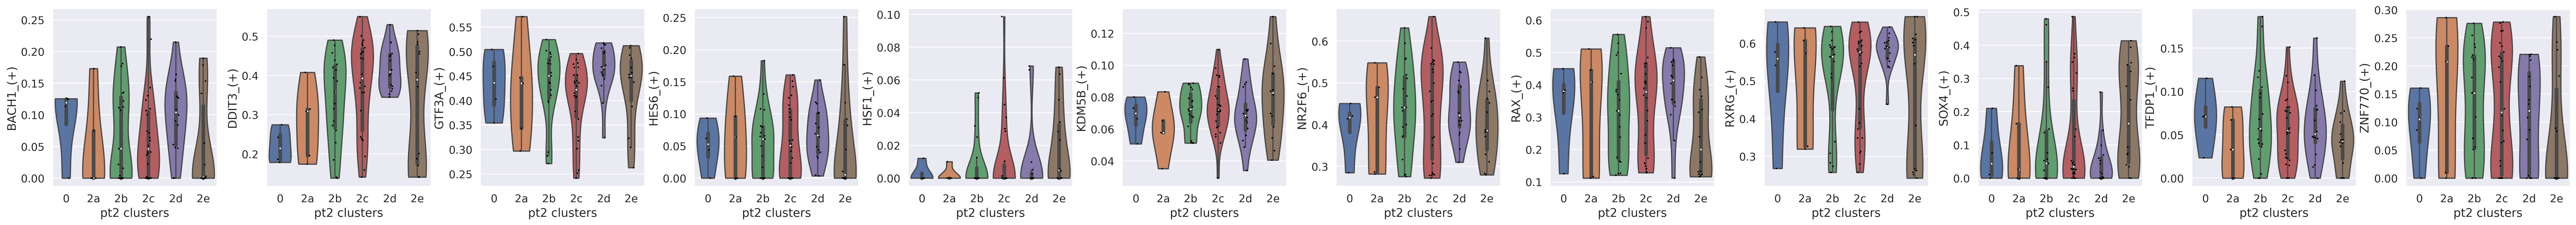

In [63]:
sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt2_clusters", log=False, stripplot=True, size = 2, inner = "box")

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


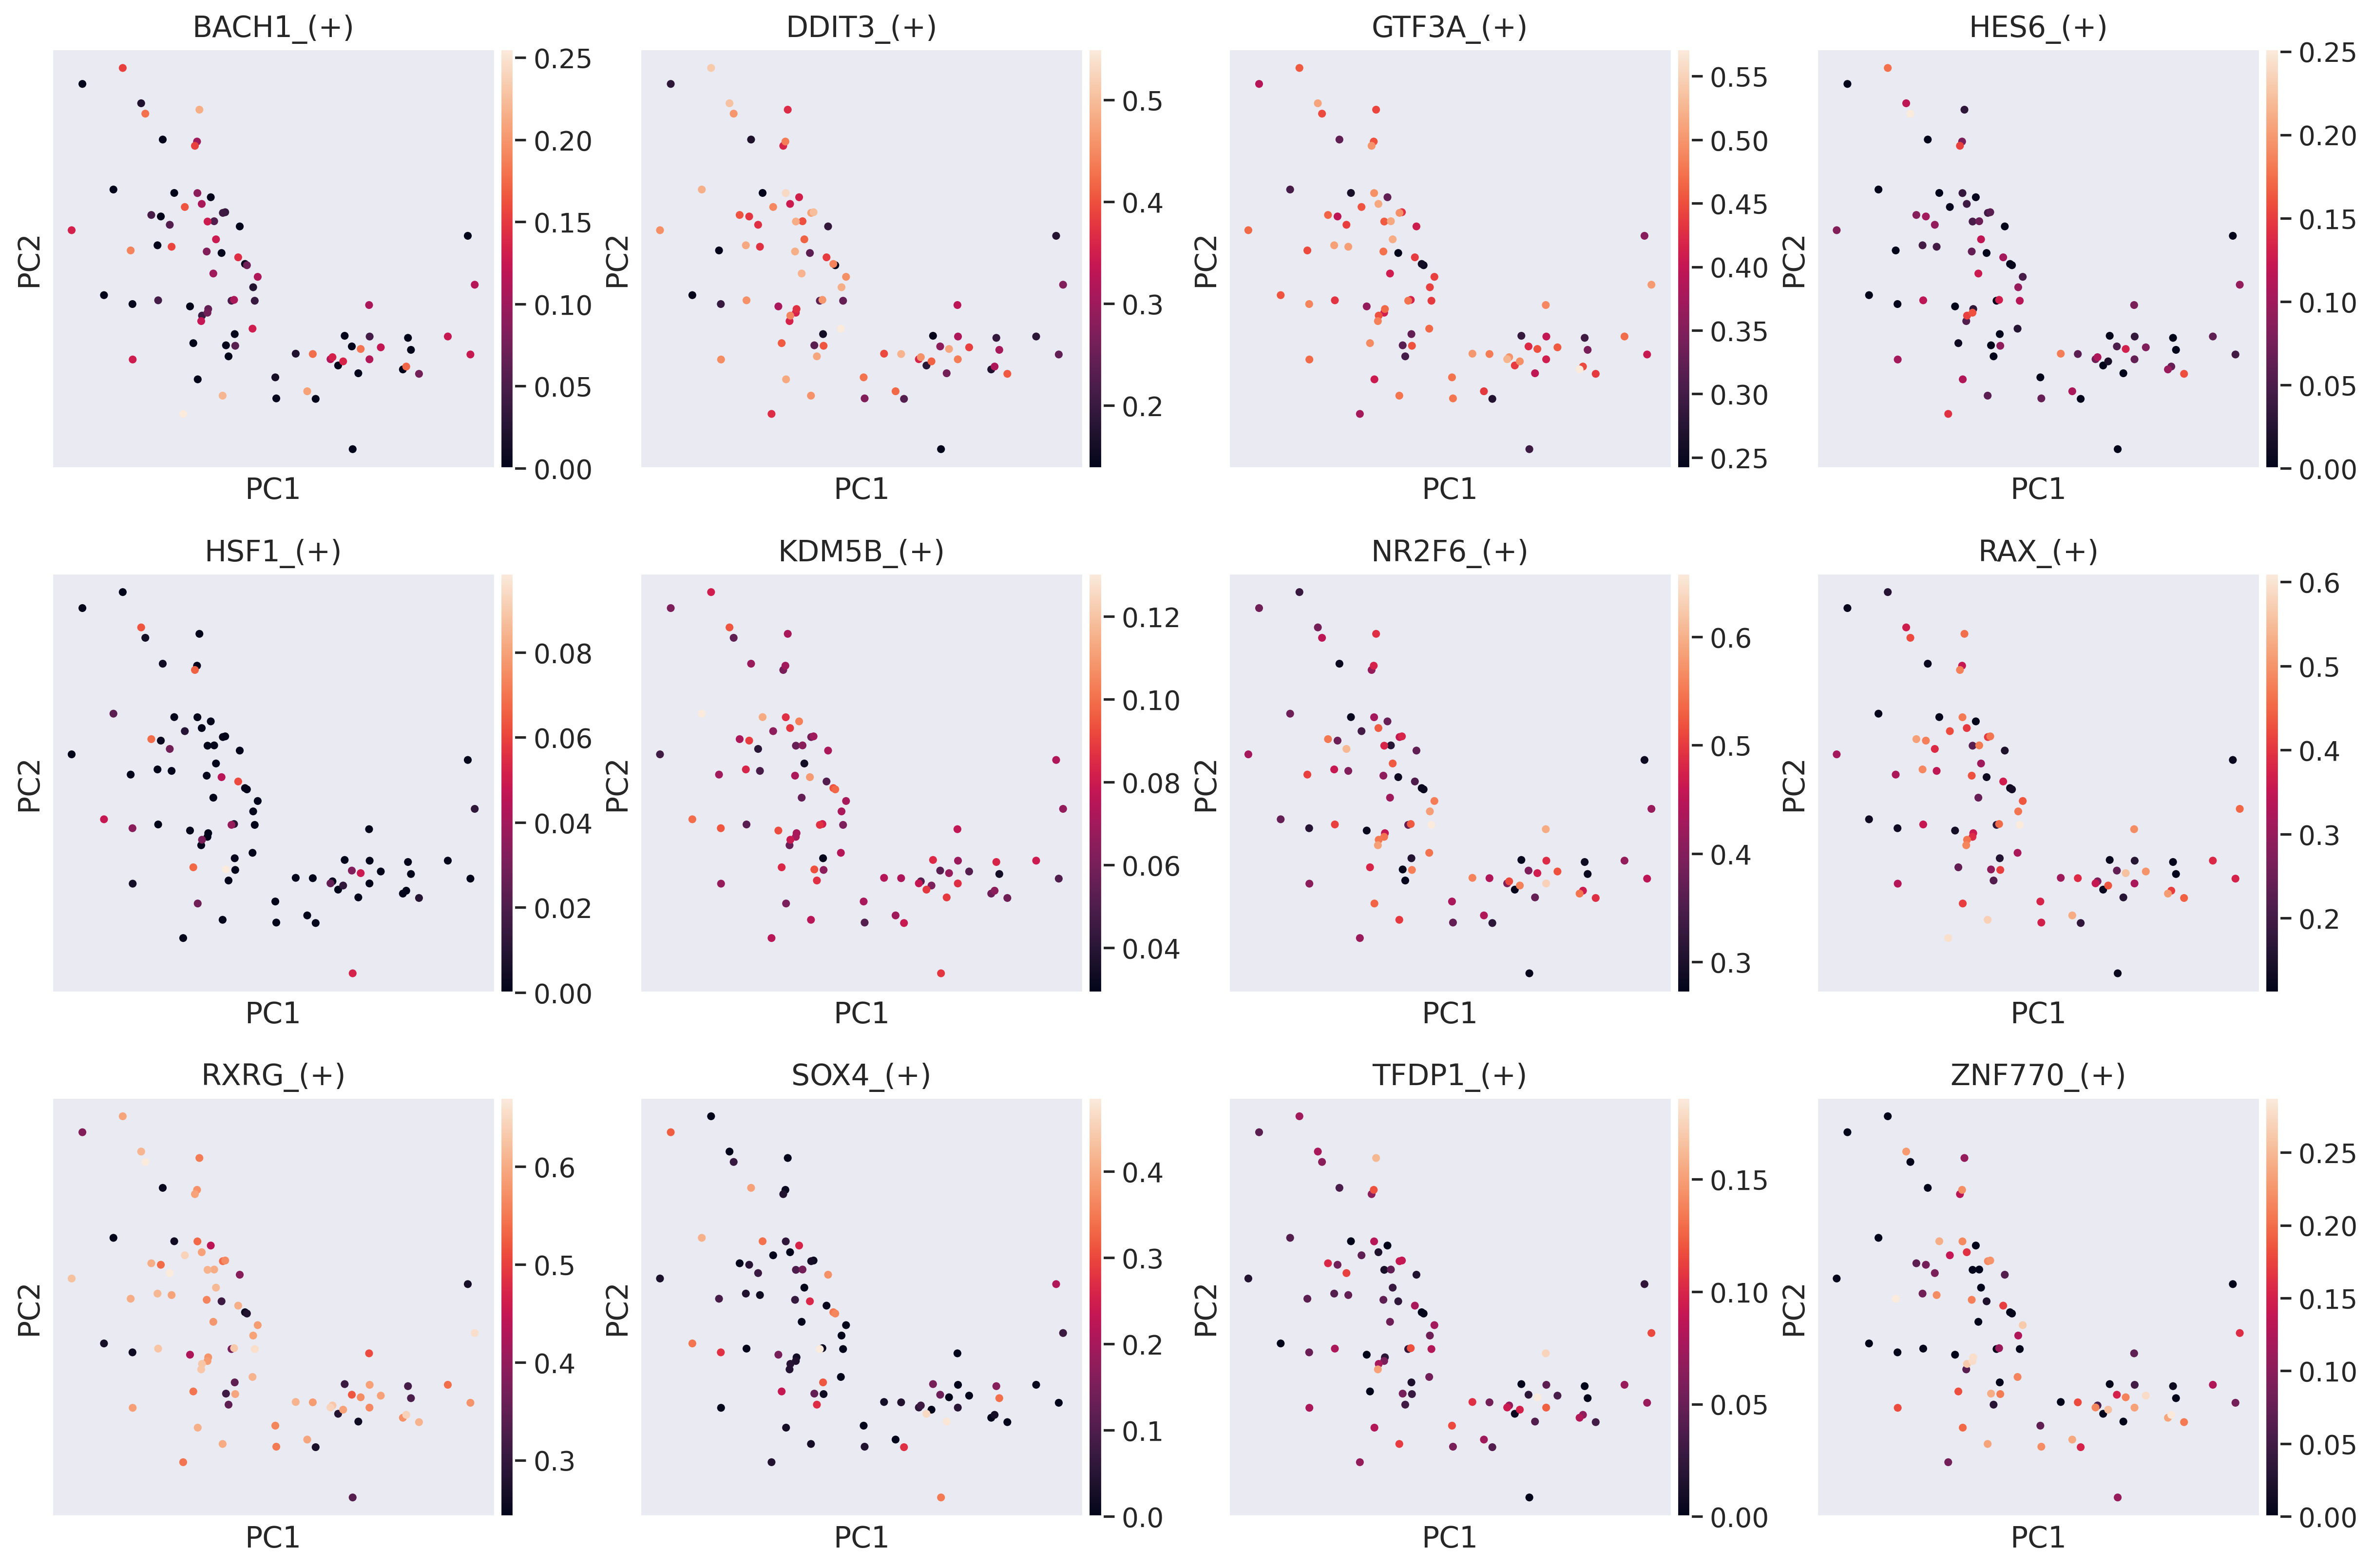

In [64]:
sc.pl.pca(adata_h5ad, components = ['1,2'], color=auc_mtx.columns, size=60, save='.pdf')

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


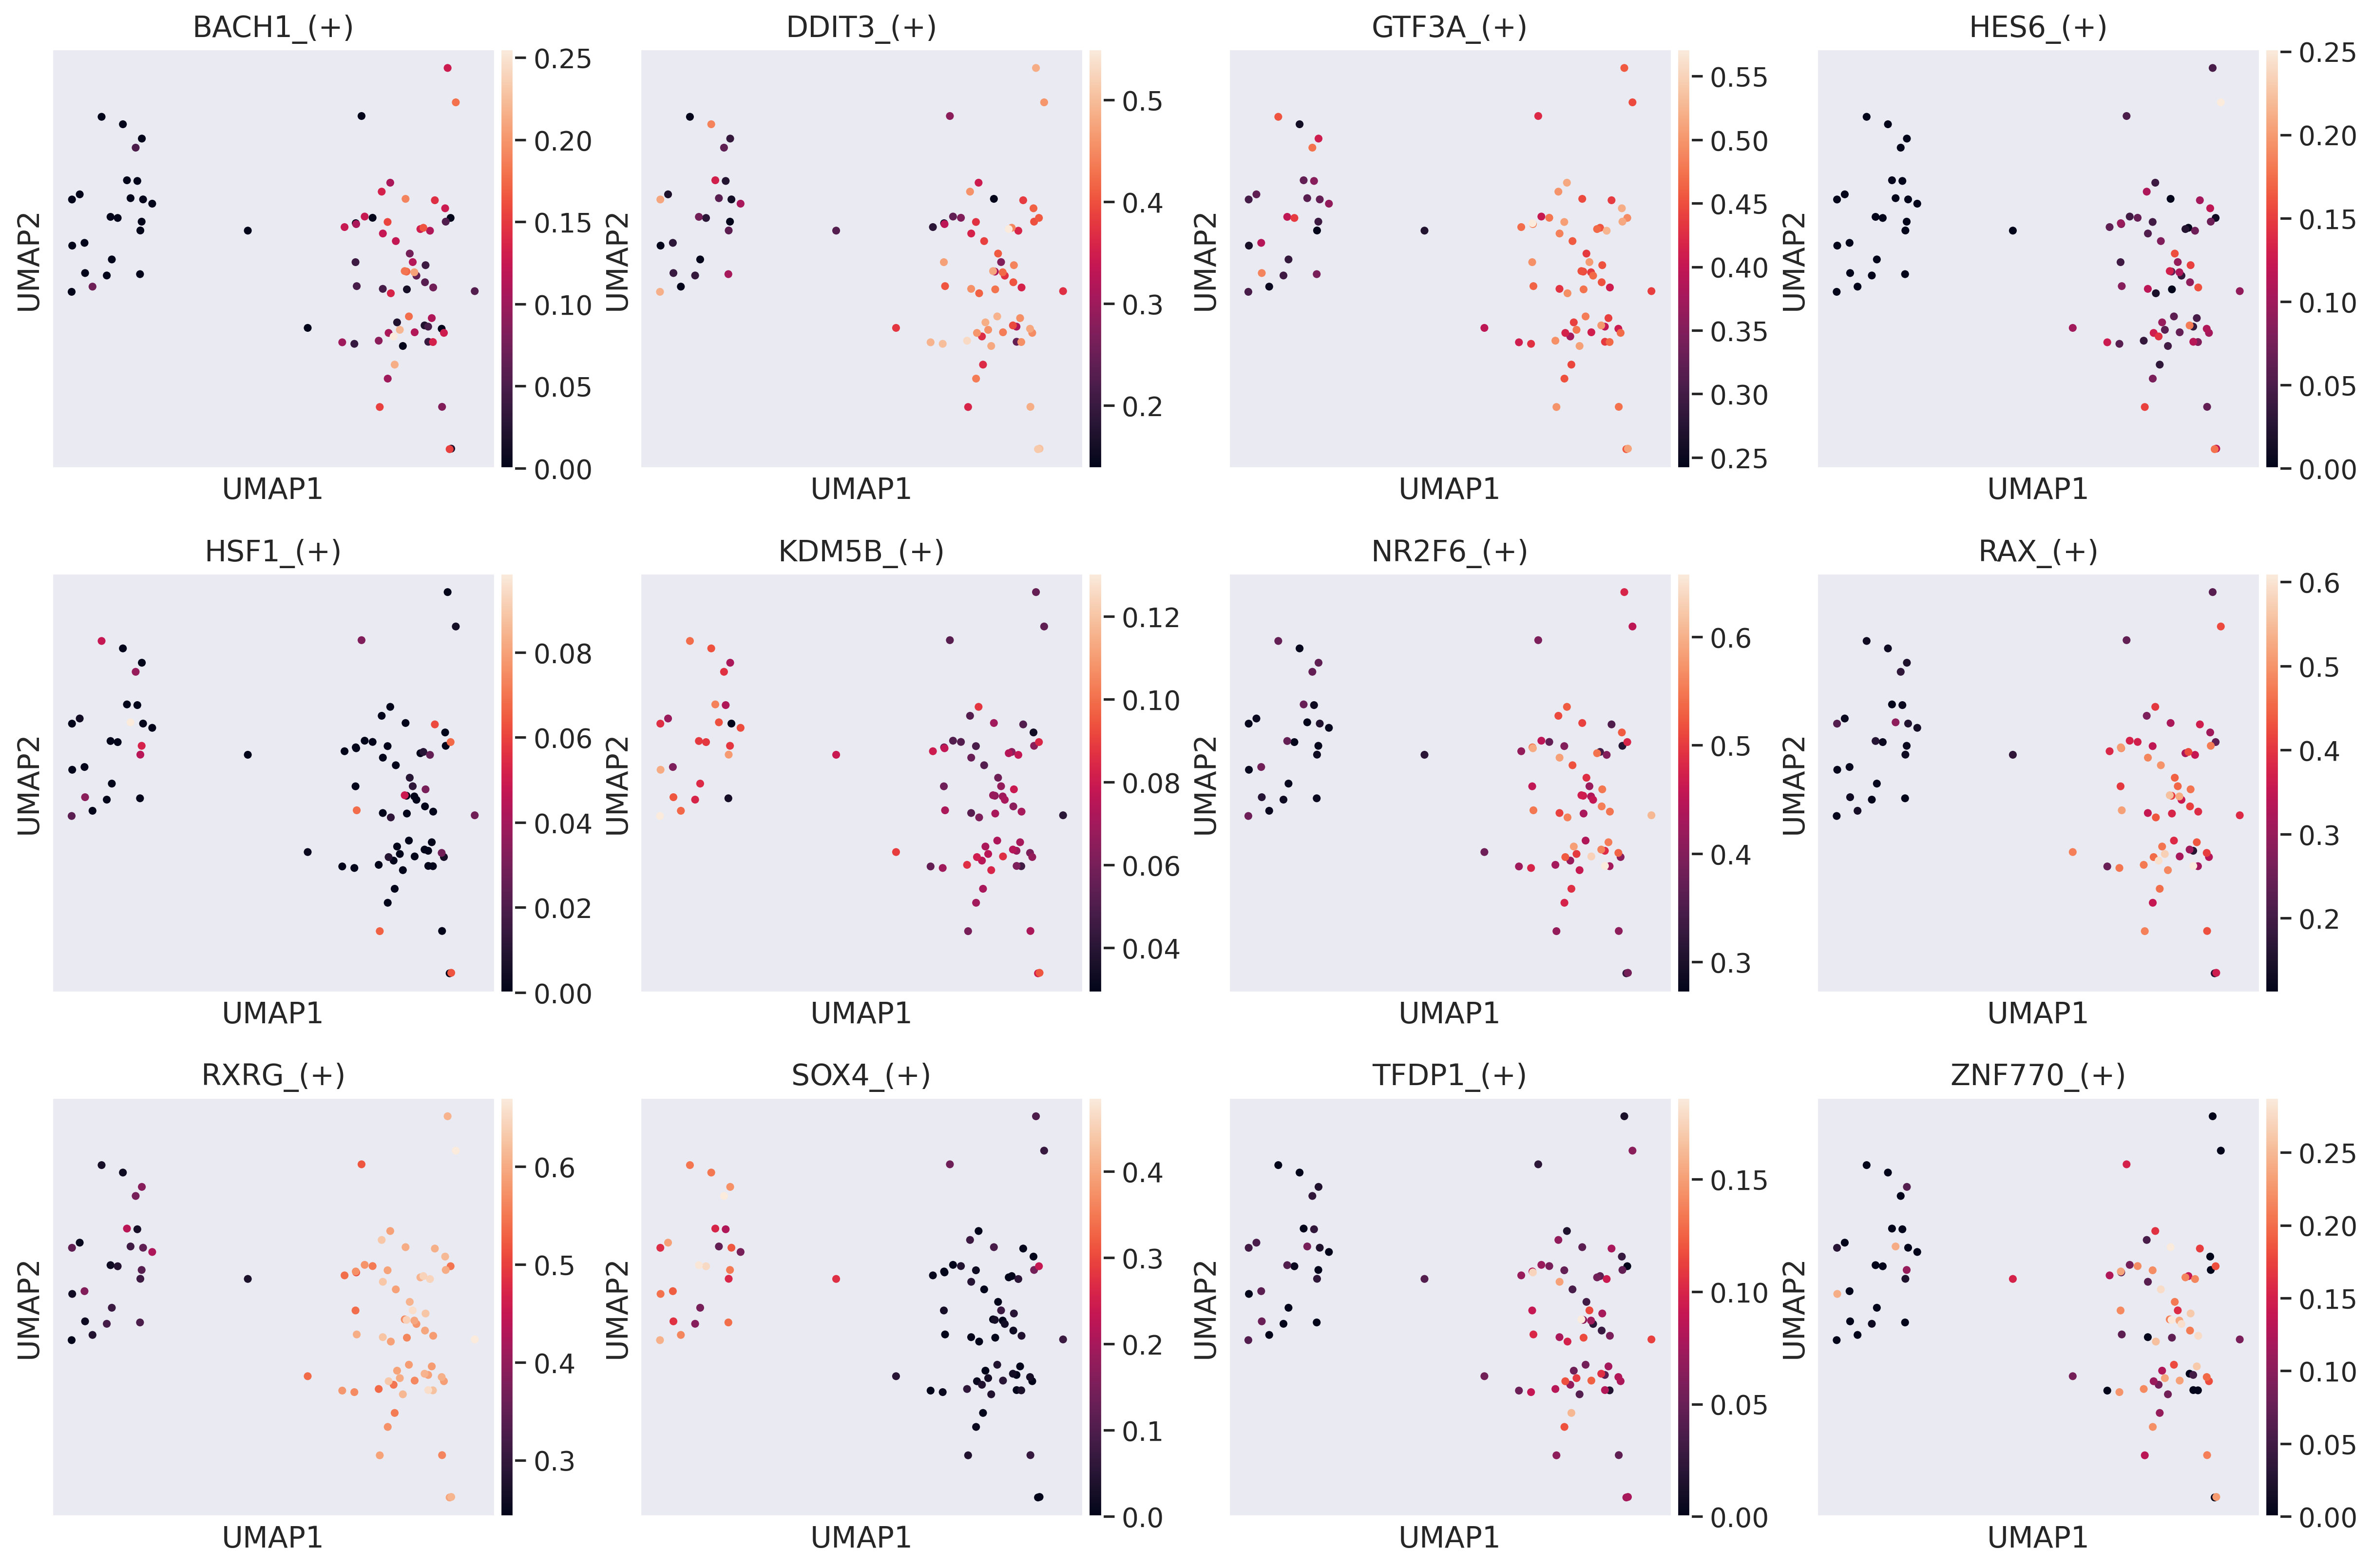

In [65]:
sc.pl.umap(adata_h5ad, color=auc_mtx.columns, size=60, save='.pdf')